# Use the Model in the Real World

- Use data of GF satallite
- Test if out trained model (trained on massachusetts-roads-dataset) can do the task

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import numpy as np

from models import DLinkNet34, LinkNet34, FarSegNet

In [2]:
FIG_SAVE_PATH = 'predict_result/mid_report/'

In [3]:
def plt_improve(p):
    p.xticks([])
    p.yticks([])

In [4]:
img_path = '/home/renyan/ossdata/gf-yunnan/IMG_0336.JPG'

In [5]:
img = cv2.imread(img_path)
img_part = img[0:1500,0:1500] * 4

In [6]:
transform = transforms.Compose([transforms.Resize([256, 256], 0), transforms.ToTensor(),])
img_part = transform(Image.fromarray(img))

In [7]:
img_part.shape

torch.Size([3, 256, 256])

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LinkNet34.LinkNet34().to(device)
net.load_state_dict(torch.load('checkpoints/v2_linknet34_re_epoch20.pth'))

<All keys matched successfully>

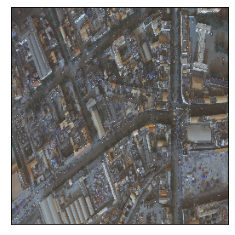

In [10]:
plt.imshow(img_part.permute(1, 2, 0))
plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'img_gf_1.png', bbox_inches='tight')

In [13]:
img_part_edit = img_part.permute(1, 2, 0)

In [19]:
import math

img1=img_part_edit
#图像格式转换
# img10=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img10 = img1
 
#计算JD
I=2003
J=2
K=20
JD=K-32075+1461*(I+4800+ (J-14)/12)/4+367*(J-2-(J-14)/12*12)/12-3*((I+4900+(J-14)/12)/100)/4
#设置ESUNI值
ESUNI71=196.9
#计算日地距离D
D=1-0.01674*math.cos((0.9856*(JD-4)*math.pi/180))
#计算太阳天顶角
cos=math.cos(math.radians(90-41.3509605))
 
inter=(math.pi*D*D)/(ESUNI71*cos*cos)
 
#大气校正参数设置
Lmini=-6.2
Lmax=293.7
Qcal=1
Qmax=255
LIMIN=Lmini+(Qcal*(Lmax-Lmini)/Qmax)
LI=(0.01*ESUNI71*cos*cos)/(math.pi*D*D)
Lhazel=LIMIN-LI
 
 
def copy(img,new1):
    new1= np.zeros(img.shape,dtype='uint16')
    new1[:,:] = img[:,:]
 
def computL(gain,Dn,bias):
    return (gain*Dn+bias)

#计算图像反射率 
result=np.zeros(img10.shape,dtype='uint16')
for i in range(0,img10.shape[0]):
    for j in range(0,img10.shape[1]):
        Lsat=computL(1.18070871,img10[i,j],-7.38070852)
        result[i,j]=inter*(Lsat-Lhazel)*1000

In [20]:
rmin = result.min()
rmax = result.max()
result2 = (result - rmin)/(rmax - rmin)

In [84]:
img_part2 = torch.tensor(result2).permute(2, 0, 1).float()

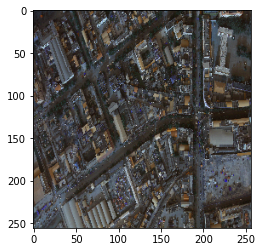

In [88]:
plt.imshow(img_part2.permute(1, 2, 0))

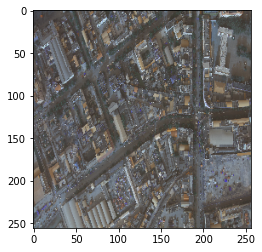

In [89]:
plt.imshow(img_part.permute(1,2,0))

In [102]:
# pred = net(img_part2.unsqueeze(dim=0).to(device))
# pred = (torch.sigmoid(pred).squeeze(0) > 0.51).type(torch.float32)
# pred1 = torch.cat([pred]*3).permute(1, 2, 0)
# plt.imshow(pred1.cpu())
# plt_improve(plt)

In [103]:
# net = DLinkNet34.DLinkNet34().to(device)
# net.load_state_dict(torch.load('checkpoints/v2_dlinknet34_re_epoch20.pth'))

In [104]:
# pred = net(img_part.unsqueeze(dim=0).to(device))
# pred = (torch.sigmoid(pred).squeeze(0) > 0.51).type(torch.float32)
# pred2 = torch.cat([pred]*3).permute(1, 2, 0)
# plt.imshow(pred2.cpu())
# plt_improve(plt)

## FarSeg

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = FarSegNet.FarSegNet().to(device)
net.eval()
net.load_state_dict(torch.load('checkpoints/' + 'v2_farseg_epoch100.pth'))

<All keys matched successfully>

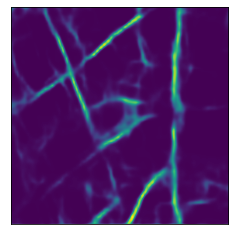

In [110]:
probs, preds = net(img_part.unsqueeze(dim=0).to(device))
pred = (probs > 0.2).float()
plt.imshow(torch.cat([pred.squeeze().unsqueeze(dim=0)]*3).permute(1, 2, 0).cpu().detach().numpy())

plt.imshow(probs.squeeze().cpu().detach().numpy()*5)
plt_improve(plt)

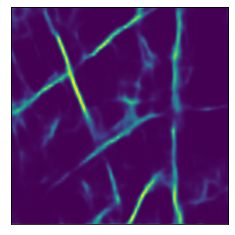

In [101]:
probs, preds = net(img_part2.unsqueeze(dim=0).to(device))
pred = (probs > 0.2).float()
plt.imshow(torch.cat([pred.squeeze().unsqueeze(dim=0)]*3).permute(1, 2, 0).cpu().detach().numpy())

plt.imshow(probs.squeeze().cpu().detach().numpy()*5)
plt_improve(plt)

In [69]:
tmp = torch.cat([probs.squeeze().unsqueeze(dim=0)]*3).permute(1, 2, 0)

In [71]:
# plt.hist(probs.flatten().detach().cpu().numpy())

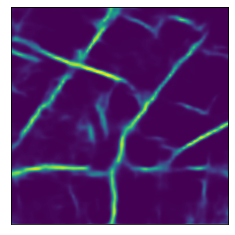

In [72]:
plt.imshow(probs.squeeze().cpu().detach().numpy()*5)
plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'pred_gf_1_channel1.png', bbox_inches='tight')

In [ ]:
tmp = torch.cat([probs.squeeze(0)]*3).permute(1, 2, 0).detach().cpu().numpy()

In [ ]:
import utils
import matplotlib.pyplot as plt

plt.imshow(utils.change_tensor_to_plot(tmp))
plt_improve(plt)
# plt.savefig(FIG_SAVE_PATH + 'pred_gf_1_channel3.png', bbox_inches='tight')

In [ ]:
pred1.max()

In [ ]:
predtmp = (tmp > 0.3).astype(float)
kernel = np.ones((3,3), np.uint8)
erorsion_img = cv2.erode(predtmp, kernel, iterations=1)
plt.imshow(erorsion_img)
plt_improve(plt)

In [ ]:
pred1.shape